# 모델3 : 강철판

## 모델구성
- pilo1
  - 레거시모델과 가장 유사하게 모델 구성
  - 데이터 표준화
  - 은닉층2개
    - 배치정규화, 드롭아웃(0.0001)
  - 최적모델 = `val_loss` 기준
- pilot2
  - 모델 구성 : 장구모양
    - 은닉층9개
  - 과적합방지 : 얼리스타핑, 드롭아웃(0.001), 커널정규화(L1,L2)
  - 학습률조정 : CosineDecay

## 가설 : 편향된 타겟에 대하여 가중치를 적용하면 성능이 오를 것
- 초기가중치, 학습가중치 적용
- 체크포인트를 val-recall 로 수정

## 결과
- 기존모델의 성능
  - Epoch : 10 , lr : 0.001
  - Train Loss : 1.014
  - Test Accuracy = 0.976
  - Test Precision = 0.926
  - Test Recall = 0.789
  - Test F1 = 0.852
- pilot1
  - Test Loss : 0.072 / Recall : 0.839
- pilot2
  - Test Loss : 0.082 / Recall : 0.845
- 모델링 결과
  - Test Loss : 0.556 / Recall : 0.950
- 평가
  - Recall 성능은 올랐지만, 다른 평가지표가 전반적으로 하락하였음
  - Recall에 최적화된 모델이 구성되었음

## 링크
- [텐서플로우 불균형 데이터 분류](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=ko)

In [1]:
# Tensorflow Check
import tensorflow as tf
from tensorflow.python.client import device_lib
import sys
print(f'Python     : {sys.version.split("|")[0]}')
print(f'Tensorflow : {tf.__version__}')
print(f'TF GPU     : {"True" if device_lib.list_local_devices()[1] else "False"}')

Python     : 3.10.11 
Tensorflow : 2.10.1
TF GPU     : True


In [2]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score

from tensorflow import keras
from IPython.display import clear_output
import json

# 각종 변수 선언
csv_path = 'D:/coding/aib/GPTeachersDay/TeamProject1/leeyeonjun/Data/binary_classification_data.csv'
EPOCHS = 1000
MB_SIZE = 2048

In [3]:
# 필요한 함수 / 메소드 정의
class CustomCallback(keras.callbacks.Callback):
    """
    사용자 정의 콜백함수
    """
    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("End training")
        # clear_output(wait=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:print()
        if epoch % 10 == 0:
            print(f'{epoch} / ', end='')

def load_data(csv_path, TRAIN_RATIO=0.8):
    global X, y, X_train, X_test, y_train, y_test, df
    
    # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # 학습 데이터 분리
    X = df.drop('target_class', axis=1)
    y = df['target_class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    # 표준화
    scaler = StandardScaler() 
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

def get_model(shape, dout=0.01, output_bias=None):
    
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    
    regularizer=keras.regularizers.L1L2(l1=0.001, l2=0.001)
    
    inputs  = keras.Input(shape=shape)

    dense1  = keras.layers.Dense(8, kernel_regularizer=regularizer)(inputs)
    norm1   = keras.layers.BatchNormalization()(dense1)
    relu1   = keras.layers.Activation('relu')(norm1)
    dout1   = keras.layers.Dropout(dout)(relu1)
    
    dense2  = keras.layers.Dense(7, kernel_regularizer=regularizer)(dout1)
    norm2   = keras.layers.BatchNormalization()(dense2)
    relu2   = keras.layers.Activation('relu')(norm2)
    dout2   = keras.layers.Dropout(dout)(relu2)
    
    dense3  = keras.layers.Dense(6, kernel_regularizer=regularizer)(dout2)
    norm3   = keras.layers.BatchNormalization()(dense3)
    relu3   = keras.layers.Activation('relu')(norm3)
    dout3   = keras.layers.Dropout(dout)(relu3)
    
    dense4  = keras.layers.Dense(5, kernel_regularizer=regularizer)(dout3)
    norm4   = keras.layers.BatchNormalization()(dense4)
    relu4   = keras.layers.Activation('relu')(norm4)
    dout4   = keras.layers.Dropout(dout)(relu4)
    
    dense5  = keras.layers.Dense(4, kernel_regularizer=regularizer)(dout4)
    norm5   = keras.layers.BatchNormalization()(dense5)
    relu5   = keras.layers.Activation('relu')(norm5)
    dout5   = keras.layers.Dropout(dout)(relu5)
    
    concat1  = keras.layers.Concatenate(axis=1)([dout5, dout4])
    dense6  = keras.layers.Dense(5, kernel_regularizer=regularizer)(concat1)
    norm6   = keras.layers.BatchNormalization()(dense6)
    relu6   = keras.layers.Activation('relu')(norm6)
    dout6   = keras.layers.Dropout(dout)(relu6)
    
    concat2  = keras.layers.Concatenate(axis=1)([dout6, dout3])
    dense7  = keras.layers.Dense(6, kernel_regularizer=regularizer)(concat2)
    norm7   = keras.layers.BatchNormalization()(dense7)
    relu7   = keras.layers.Activation('relu')(norm7)
    dout7   = keras.layers.Dropout(dout)(relu7)
    
    concat3  = keras.layers.Concatenate(axis=1)([dout7, dout2])
    dense8  = keras.layers.Dense(7, kernel_regularizer=regularizer)(concat3)
    norm8   = keras.layers.BatchNormalization()(dense8)
    relu8   = keras.layers.Activation('relu')(norm8)
    dout8   = keras.layers.Dropout(dout)(relu8)
    
    concat4  = keras.layers.Concatenate(axis=1)([dout8, dout1])
    dense9  = keras.layers.Dense(8, kernel_regularizer=regularizer)(concat4)
    norm9   = keras.layers.BatchNormalization()(dense9)
    relu9   = keras.layers.Activation('relu')(norm9)
    dout9   = keras.layers.Dropout(dout)(relu9)
    
    outputs = keras.layers.Dense(1, activation='sigmoid'
                                 , bias_initializer=output_bias)(dout9)
    model   = keras.Model(inputs, outputs, name='Star_Model')
    
    METRICS = [
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
            ]
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS
        )
    return model

In [4]:
load_data(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.describe()

(14318, 8) (3580, 8) (14318,) (3580,)


,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
count,1.431800e+04,1.431800e+04,1.431800e+04,1.431800e+04,1.431800e+04,1.431800e+04,14318.000000,1.431800e+04
mean,4.937771e-17,1.985033e-17,4.168570e-17,1.215833e-17,2.679795e-17,4.081725e-17,0.000000,6.252855e-17
std,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035,1.000035e+00
min,-4.120136e+00,-3.207467e+00,-2.235779e+00,-5.770065e-01,-4.188843e-01,-9.702420e-01,-2.481473,-1.010623e+00
25%,-4.023072e-01,-6.137926e-01,-4.266299e-01,-3.186363e-01,-3.605269e-01,-6.075160e-01,-0.564632,-6.588786e-01
50%,1.541275e-01,6.343979e-02,-2.415434e-01,-2.553492e-01,-3.306753e-01,-4.016201e-01,0.028258,-2.053026e-01
75%,6.282295e-01,6.600747e-01,-6.613046e-04,-1.334971e-01,-2.407483e-01,1.029766e-01,0.531815,3.272613e-01
max,3.198297e+00,6.588416e+00,7.212419e+00,1.092778e+01,6.832434e+00,4.346189e+00,5.834657,1.022672e+01


In [5]:
# 초기 가중치 적용
neg, pos = np.bincount(y)
total = neg + pos
initial_bias = np.log([pos/neg])
initial_bias

array([-2.2945603])

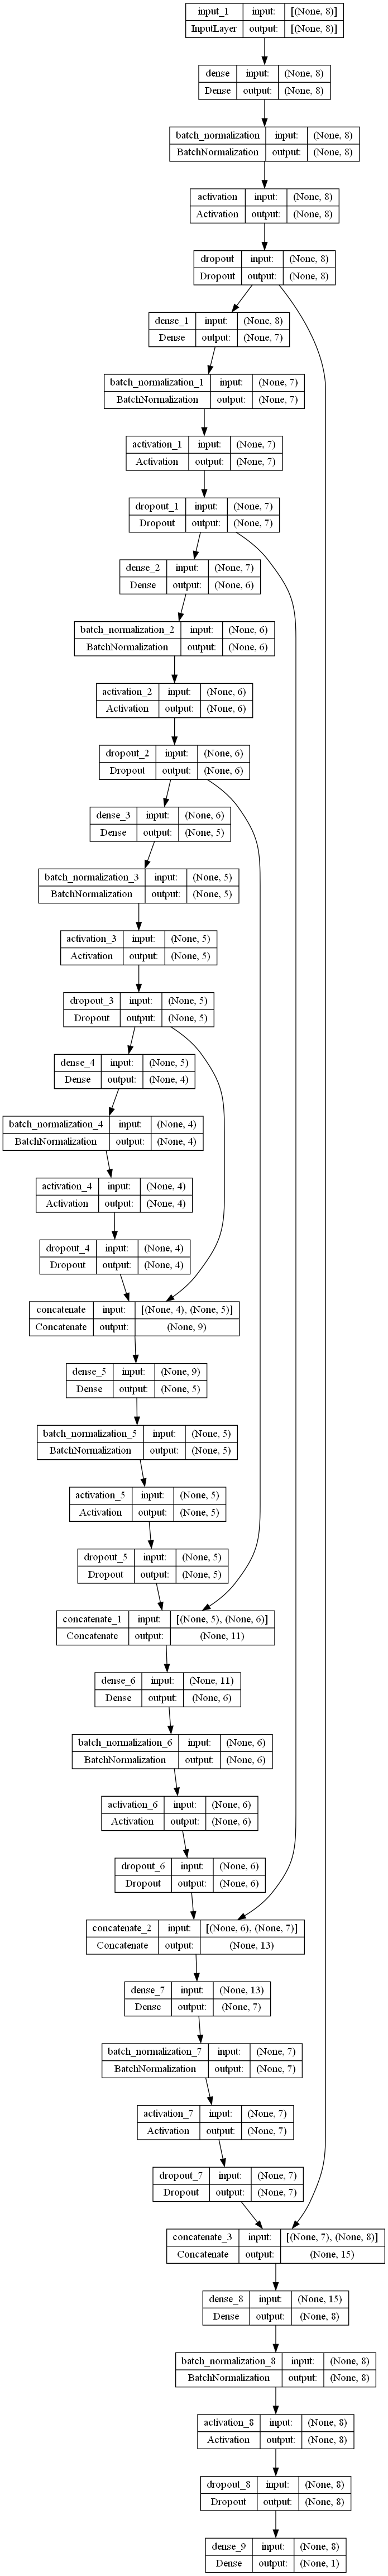

In [6]:
model = get_model(len(X_train.columns), output_bias=initial_bias)
keras.utils.plot_model(model, show_shapes=True, to_file='model2_model.png')

In [7]:
model.save_weights('initial_weights.h5')
model = get_model(len(X_train.columns))
model.load_weights('initial_weights.h5')

In [8]:
print(pos/total)
model.predict(X_train[:10])

0.09157447759526204
1/1 [==============================] - 1s 976ms/step


array([[0.07599257],
       [0.6288985 ],
       [0.0919131 ],
       [0.10808019],
       [0.09891411],
       [0.09864671],
       [0.1026684 ],
       [0.09804973],
       [0.11196933],
       [0.0998717 ]], dtype=float32)

In [9]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * ((neg+pos) / 2.0)
weight_for_1 = (1 / pos) * ((neg+pos) / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.46


In [10]:
# 얼리스타핑
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss'
                                        , min_delta=0.000001
                                        , mode='auto'
                                        , patience=EPOCHS//2)

# 모델 저장
checkpoint_path = './model2.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
                                        checkpoint_path
                                        , monitor='val_loss'
                                        , verbose=0
                                        , mode = 'auto'
                                        , save_best_only=True
                                        , save_weights_only=False)

# 학습률 조정
lr_decay = keras.optimizers.schedules.CosineDecay(
                                        initial_learning_rate=0.01
                                        , decay_steps=EPOCHS
                                        , alpha=1e-16)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# 모델 학습
history = model.fit(X_train, y_train
                , batch_size=MB_SIZE
                , validation_split = 0.2
                , verbose=0
                , epochs=EPOCHS
                , callbacks=[earlystop, checkpoint, CustomCallback(), lr_scheduler]
                , class_weight=class_weight
                )

Starting training

0 / 10 / 20 / 30 / 40 / 50 / 60 / 70 / 80 / 90 / 
100 / 110 / 120 / 130 / 140 / 150 / 160 / 170 / 180 / 190 / 
200 / 210 / 220 / 230 / 240 / 250 / 260 / 270 / 280 / 290 / 
300 / 310 / 320 / 330 / 340 / 350 / 360 / 370 / 380 / 390 / 
400 / 410 / 420 / 430 / 440 / 450 / 460 / 470 / 480 / 490 / 
500 / 510 / 520 / 530 / 540 / 550 / 560 / 570 / 580 / 590 / 
600 / 610 / 620 / 630 / 640 / 650 / 660 / 670 / 680 / 690 / 
700 / 710 / 720 / 730 / 740 / 750 / 760 / 770 / 780 / 790 / 
800 / 810 / 820 / 830 / 840 / 850 / 860 / 870 / 880 / 890 / 
900 / End training


In [11]:
# 가장 성능이 좋았던 모델을 가져와 평가
model.load_weights(checkpoint_path)
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)
f1 = f1_score(y_test, y_pred_class)
results = model.evaluate(X_test, y_test)
print(f'Test Loss : {results[0]:.3f} / Accuracy: {results[1]:.3f} / Precision: {results[2]:.3f} / Recall : {results[3]:.3f} / F1 Score: {f1:.3f}')

112/112 [==============================] - 2s 17ms/step - loss: 0.0992 - accuracy: 0.9737 - precision: 0.8499 - recall: 0.8798 - auc: 0.9738 - prc: 0.9328
Test Loss : 0.099 / Accuracy: 0.974 / Precision: 0.850 / Recall : 0.880 / F1 Score: 0.865


In [12]:
import json
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.set_index('epoch')
hist.to_json('model2.json')

In [13]:
with open('model2.json') as json_file:
    json_file = json.loads(json_file.read())
model1_hist = pd.DataFrame(json_file)
model1_hist

,loss,accuracy,precision,recall,auc,prc,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_prc,lr
0,0.715277,0.953466,0.908940,0.534567,0.889865,0.771998,0.395169,0.965084,0.890411,0.719557,0.964039,0.875966,0.010000
1,0.492560,0.964728,0.794702,0.817916,0.953521,0.860199,0.391539,0.967528,0.813380,0.852399,0.967315,0.898465,0.010000
2,0.428405,0.937053,0.600658,0.888997,0.961712,0.880175,0.392970,0.965433,0.779221,0.885609,0.970729,0.904336,0.010000
3,0.400064,0.944474,0.634364,0.898734,0.967192,0.897976,0.386899,0.963338,0.757764,0.900369,0.974838,0.908547,0.010000
4,0.381348,0.955387,0.695455,0.893866,0.967545,0.903010,0.376802,0.960894,0.738739,0.907749,0.977310,0.910527,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,0.134041,0.969443,0.772764,0.933788,0.989058,0.935043,0.131742,0.971718,0.802548,0.929889,0.987562,0.944175,0.000259
898,0.137073,0.970578,0.783251,0.928919,0.988216,0.935469,0.130925,0.971718,0.802548,0.929889,0.987402,0.943940,0.000255
899,0.135776,0.969967,0.778776,0.928919,0.988521,0.936123,0.132179,0.971369,0.800000,0.929889,0.987286,0.943651,0.000250
900,0.135665,0.971800,0.791391,0.930867,0.988590,0.936213,0.133385,0.971718,0.802548,0.929889,0.987296,0.943752,0.000245


In [14]:
model1_hist.sort_values(by=['val_loss'], ascending=True).iloc[:5,:]

,loss,accuracy,precision,recall,auc,prc,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_prc,lr
401,0.152028,0.967173,0.760192,0.925998,0.985762,0.928319,0.090068,0.977304,0.847973,0.926199,0.988304,0.951976,0.006530
402,0.149135,0.970141,0.780508,0.927945,0.986401,0.933765,0.090571,0.979050,0.862543,0.926199,0.988171,0.953900,0.006515
397,0.154975,0.963244,0.730945,0.933788,0.985389,0.925980,0.091599,0.978352,0.859107,0.922509,0.987666,0.943557,0.006590
398,0.157866,0.967173,0.763137,0.919182,0.984483,0.929077,0.094767,0.975209,0.831126,0.926199,0.988804,0.947618,0.006575
90,0.167677,0.965863,0.753588,0.920156,0.982569,0.924798,0.097110,0.980447,0.911877,0.878229,0.988997,0.950748,0.009801


112/112 [==============================] - 1s 7ms/step


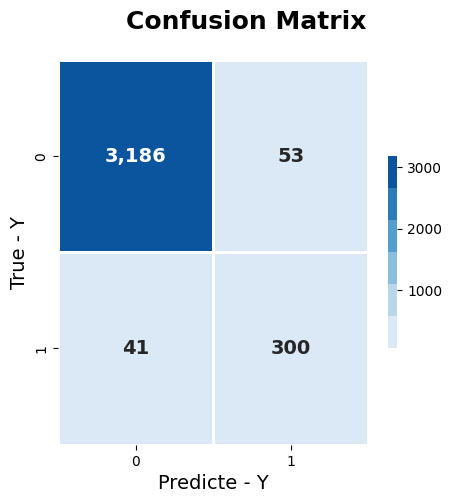

In [15]:
c_mat = confusion_matrix(y_test, model.predict(X_test).round())

# 히트맵을 그린다
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Confusion Matrix', fontsize = 18, fontweight = 'bold')
sns.heatmap(c_mat, 
            cmap = sns.color_palette('Blues'), 
            annot = True,
            annot_kws = {'fontweight':'bold','size':14},
            fmt=',.0f',
            linewidths = 2,
            cbar_kws = {'shrink': .5},
           )

plt.xlabel('Predicte - Y', fontsize = 14)
plt.ylabel('True - Y', fontsize = 14)
plt.show()

fig.savefig('model2_cm.png', dpi=80, bbox_inches='tight')

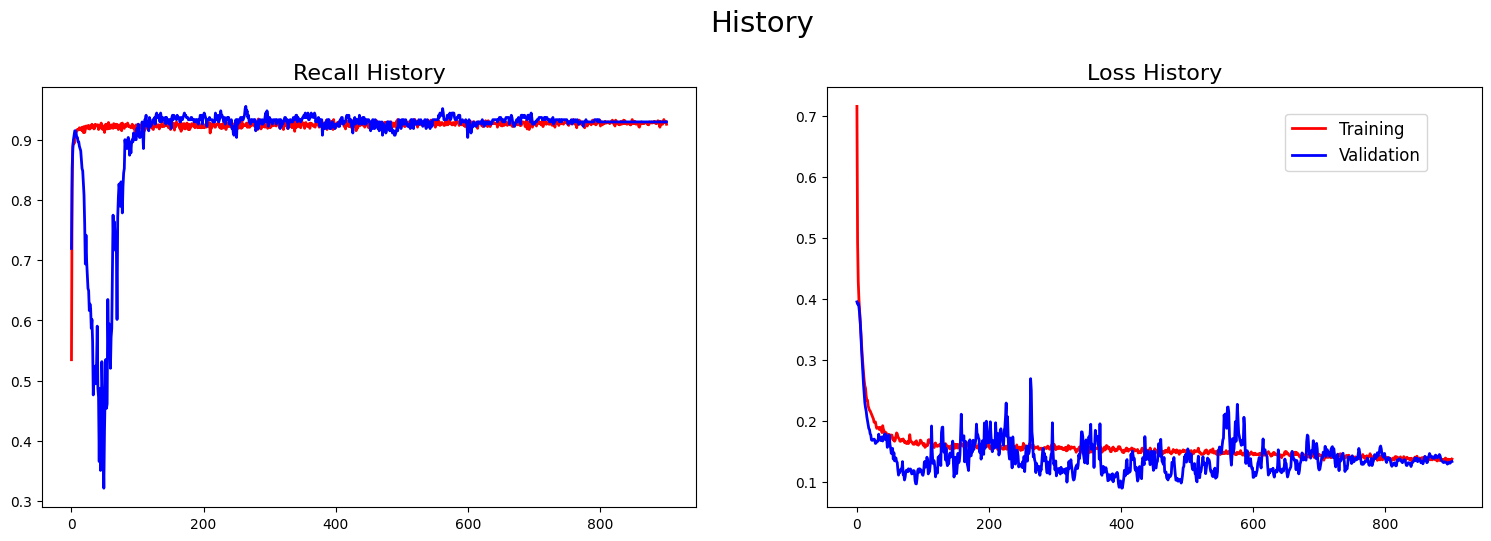

In [16]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Recall Plot
ax = plt.subplot(1, 2, 1)
plt.title(f'Recall History', fontsize = 16, y = 1)
plt.plot(history.history["recall"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_recall"], color='b', linewidth=2, label="Validation")

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title(f'Loss History', fontsize = 16, y = 1)
plt.plot(history.history["loss"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_loss"], color='b', linewidth=2, label="Validation")

plt.legend(fontsize=12, loc=(0.7, 0.8))
plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()

fig.savefig('model2_history.png', dpi=80, bbox_inches='tight')